### 2번
5분간격의 가구별 전력 사용량의 데이터
데이터 출처 : 자체생성

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('C:/Users/LG/Desktop/problem2.csv')

In [58]:
df.sort_values(by = ['houseCode','date']).head(5)
df_2 = df.sort_values(by = ['houseCode','date']).reset_index()
# 각 houseCode 별 5분간격 date-> 15분단위로 구성하고 그에 따른 그룹핑하기

In [59]:
df_2.head()

,index,houseCode,date,power consumption
0,49500,house_00,2050-01-01 00:00:00,58.253938
1,378302,house_00,2050-01-01 00:05:00,21.731130
2,350416,house_00,2050-01-01 00:10:00,56.264884
3,362798,house_00,2050-01-01 00:15:00,27.894691
4,248593,house_00,2050-01-01 00:20:00,24.690939


In [60]:
df_2['date_type'] = pd.to_datetime(df_2['date'])

In [61]:
# % : 나머지 //: 몫 
# 파이썬 모르겟음.. 아래 values () 해서 array 여야 붙일수잇는건가?
df_2['minute_group'] = (df_2['date_type'].dt.minute // 15).values
df_2 = df_2.drop('index', axis=1)

In [63]:
df_2.groupby('houseCode','minute_group').agg('min')['power consumption']

,houseCode,date,power consumption,date_type,minute_group
0,house_00,2050-01-01 00:00:00,58.253938,2050-01-01 00:00:00,0
1,house_00,2050-01-01 00:05:00,21.731130,2050-01-01 00:05:00,0
2,house_00,2050-01-01 00:10:00,56.264884,2050-01-01 00:10:00,0
3,house_00,2050-01-01 00:15:00,27.894691,2050-01-01 00:15:00,1
4,house_00,2050-01-01 00:20:00,24.690939,2050-01-01 00:20:00,1


In [79]:
group_df =df_2.groupby(['houseCode','minute_group']).agg('min')['power consumption'].to_frame().reset_index()
date_df = df_2.groupby(['houseCode','minute_group']).agg('min')['date_type'].to_frame().reset_index()

In [87]:
# pd.merge(df, other, left_on = 'key', right_on = 'key')
df_final = pd.merge(group_df, date_df).drop('minute_group', axis=1)

In [88]:
## 2-1) 15분간격의 전력량의 합
df_final.head(4)

,houseCode,power consumption,date_type
0,house_00,0.136960,2050-01-01 00:00:00
1,house_00,0.070351,2050-01-01 00:15:00
2,house_00,0.033025,2050-01-01 00:30:00
3,house_00,0.001621,2050-01-01 00:45:00


2-1 데이터 전처리

각 가구의 15분간격의 전력량의 합을 구하고 해당데이터를 바탕으로 총 5개의 군집으로 군집화를 진행한 후 아래의 그림과 같은 형태로 출력하라.
군집화를 위한 데이터 구성의 이유를 설명하라
(군집 방식에 따라 Cluster컬럼의 값은 달라질수 있음)

<img width="1020" src="https://user-images.githubusercontent.com/97590480/236660968-0e59b0f9-5540-40dc-9b05-53ef6fc5a29a.png">

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


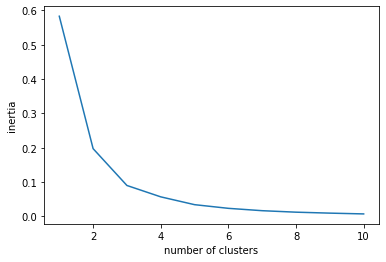

In [89]:
from sklearn.cluster import KMeans

x = np.array(df_final['power consumption']).reshape(-1,1)
inertia = []
for i in range(1,11):
    kmeans_plus = KMeans(n_clusters=i, init='k-means++')
    kmeans_plus.fit(x)
    inertia.append(kmeans_plus.inertia_)

plt.plot(range(1,11), inertia)
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.show()

In [126]:
## 클러스터링 -> 비지도학습은 평가하기 어려우나 군집화의 성능을 비교하는데 '실루엣계수' 사용

# 실루엣계수 : 각군집간 거리 얼마나 효율적 분리되어있는지 나타냄. 다른군집과 거리 떨어져있고 동일군집끼리 데이터 가까움
# 1 = 근처군집과 더 멀리 떨어져있음(잘분리) , 0 = 근처군집과 가까워짐, - = 아예다른군집에 데이터 할당
# 좋은군집 조건
# 1. 전체실루엣계수 평균값이 0~1사이, 1가까울수록 좋음
# 2. 개별 군집의 평균값의 편차 크지않아야 함(즉 개별군집의 실루엣계수평균값이 전체 실루엣 계수 평균값에서 크게 벗어나지 않아야함)

## 주의: x_feature 데이터프레임 과 cluster저장할 테이블 분리해서 사용하기!
from sklearn.metrics import silhouette_score, silhouette_samples
X_feature = pd.DataFrame(df_final['power consumption']) # 학습데이터 2d array로 해줘야함
df_cluster = X_feature

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_cluster)
df_cluster['cluster'] = kmeans.labels_

## 모든 개별 데이터에 실루엣 계수값 구하기
score_samples = silhouette_samples(X_feature, df_cluster['cluster'])
df_cluster['silhouette_coeff'] = score_samples

## 평균실루엣 계수값 구함 = silhouette_score(X feature 데이터세트, 군집된 label값)
average_score = silhouette_score(X_feature, df_cluster['cluster'])
print('실루엣계수 스코어:{0:.3f}'.format(average_score))

실루엣계수 스코어:0.975


In [127]:
## 군집 칼럼별로 실루엣계수 구하기
df_cluster.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.981658
1    0.971945
2    0.945622
Name: silhouette_coeff, dtype: float64

#### 2-2 히트맵

2-1의 데이터를 바탕으로 각 군집의 요일, 15분간격별 전력사용량의 합을 구한 후 아래와 같이 시각화 하여라
(수치는 동일하지 않을 수 있음 2-1의 데이터가 정확하게 아래와 같은 이미지로 변환 됐는지 주로 확인)

<img width="878" src="https://user-images.githubusercontent.com/97590480/236660988-679620bb-d51f-4b69-9c33-edee958dc032.png">
